<a href="https://colab.research.google.com/github/lucasferreiraos/curso-aprendizado-de-maquina-na-pratica/blob/master/Redes_Neurais_Consumo_de_%C3%A1lcool_dos_estudantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve
)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('/content/drive/My Drive/Datasets/student-alcohol-consumption/student-mat.csv')

## Pré-processamento dos dados

Aqui será executado os mesmo procedimentos adotados com a Árvore de Decisão.

In [3]:
labels = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

for label in labels:
    data[label] = data[label].replace(['yes', 'no'], [1, 0])

In [4]:
data['school'] = data['school'].replace(['GP', 'MS'], [1, 0])
data['sex'] = data['sex'].replace(['F', 'M'], [1, 0])
data['address'] = data['address'].replace(['U', 'R'], [1, 0])
data['famsize'] = data['famsize'].replace(['GT3', 'LE3'], [1, 0])
data['Pstatus'] = data['Pstatus'].replace(['T', 'A'], [1, 0])

In [5]:
label_encoder = LabelEncoder()

data.Mjob = label_encoder.fit_transform(data.Mjob)
data.Fjob = label_encoder.fit_transform(data.Fjob)
data.reason = label_encoder.fit_transform(data.reason)
data.guardian = label_encoder.fit_transform(data.guardian)

data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,1,18,1,1,0,4,4,0,4,0,1,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,6,5,6,6
1,1,1,17,1,1,1,1,1,0,2,0,0,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,4,5,5,6
2,1,1,15,1,0,1,1,1,0,2,2,1,1,2,3,1,0,1,0,1,1,1,0,4,3,2,2,3,3,10,7,8,10
3,1,1,15,1,1,1,4,2,1,3,1,1,1,3,0,0,1,1,1,1,1,1,1,3,2,2,1,1,5,2,15,14,15
4,1,1,16,1,1,1,3,3,2,2,1,0,1,2,0,0,1,1,0,1,1,0,0,4,3,2,1,2,5,4,6,10,10


### Tratando o caso do desbalanceamento entre as classes

O gráfico abaixo vai nos mostrar que existe um desbalanceamento muito grande, é possível notar que a classe majoritária (nota 10) contém muito mais instâncias que as outras classes, inclusive a classe minoritária (nota 20). Pelo fato de que esses dados representam, em linhas gerais, o rendimento dos alunos do ensino secundário, nos leva a concluir que o comportamento dos dados representa bem o contexto.

Porém, mesmo sendo uma característica do contexto, tal comportamento pode ser um impeditivo na performance do classificador - além da baixa quantidade de instâncias no dataset - por ter muitas classes com um desbalanceamento muito evidente.

Podemos tomar algumas dessas decisões:
- Treinar o modelo com o dataset desbalanceado;
- Diminuir o número de classes;
- Balancear o dataset utilizando resampling e diminuir o número de classes;

A última abordagem se mostrou bem eficaz para a Árvore de Decisão. Contudo, se queremos a melhor abordagem no pré-processamento, vamos testar os 3 caminhos e discutir os resultados.

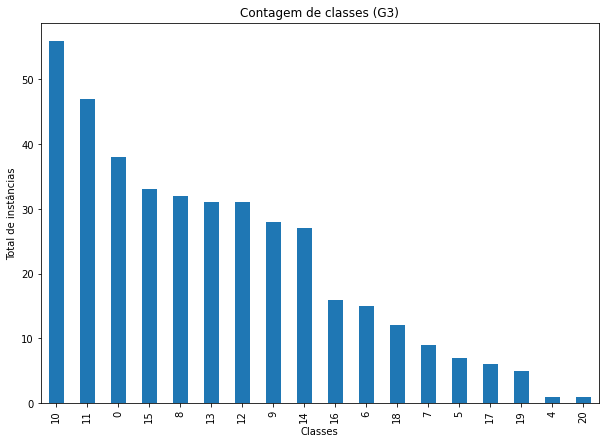

In [6]:
target_count = data.G3.value_counts()
plt.figure(figsize=(10, 7))
plt.xlabel('Classes')
plt.ylabel('Total de instâncias')
target_count.plot(kind='bar', title='Contagem de classes (G3)')

## Treinando a Rede Neural com dataset desbalanceado e as classes originais.

In [7]:
X = data.iloc[:, :-1]
y = data.G3

X = (X - X.min()) / (X.max() - X.min())
X.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
0,1.0,1.0,0.428571,1.0,1.0,0.0,1.00,1.00,0.00,1.00,0.000000,0.5,0.333333,0.333333,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.75,0.50,0.75,0.00,0.00,0.5,0.080000,0.1250,0.315789
1,1.0,1.0,0.285714,1.0,1.0,1.0,0.25,0.25,0.00,0.50,0.000000,0.0,0.000000,0.333333,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.00,0.50,0.50,0.00,0.00,0.5,0.053333,0.1250,0.263158
2,1.0,1.0,0.000000,1.0,0.0,1.0,0.25,0.25,0.00,0.50,0.666667,0.5,0.000000,0.333333,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.75,0.50,0.25,0.25,0.50,0.5,0.133333,0.2500,0.421053
3,1.0,1.0,0.000000,1.0,1.0,1.0,1.00,0.50,0.25,0.75,0.333333,0.5,0.000000,0.666667,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.50,0.25,0.25,0.00,0.00,1.0,0.026667,0.7500,0.736842
4,1.0,1.0,0.142857,1.0,1.0,1.0,0.75,0.75,0.50,0.50,0.333333,0.0,0.000000,0.333333,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.75,0.50,0.25,0.00,0.25,1.0,0.053333,0.1875,0.526316


### Otimização de parâmetros

Já que vamos testar todas as hipóteses em relação ao pré-processamento, vamos buscar o melhor conjunto de parâmetros para o nosso modelo e ver o seu resultado. Abaixo eu defini uma estrutura que se chama **espaço de soluções**, que é um conjunto de possíveis parâmetros para uma rede neural. A partir desse conjunto vamos tentar buscar pela melhor solução para todas as hipóteses que testarmos.

In [8]:
param_grid = [{
    'hidden_layer_sizes': [(30), (50, 30), (50, 100), (30, 50, 100), (50, 150, 100)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'max_iter': [500, 1000, 2000]
}]

### Método de busca

Vamos utilizar o **Randomized Search** como método de busca do melhor conjunto de parâmetros. Como o nome sugere, ele faz uma escolha aleatória dos parâmetros existentes no espaço de soluções e te entrega a melhor configuração. Por ser aleatório, ele pode acabar desconsiderando alguma combinação que possivelmente poderia ser a melhor; por outro lado, esse método é o que possui o menor tempo de execução e por isso vamos seguir com ele.

### Validação cruzada e métricas

Para a validação cruzada vamos definir `k = 10` e como métrica de score vamos usar a acurácia.

In [9]:
mlp_01 = RandomizedSearchCV(
    MLPClassifier(),
    param_grid,
    cv=10,
    scoring='accuracy'
)

In [10]:
mlp_01.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/d

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_fun=15000, max_iter=200,
                                           momentum=0.9, n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           rando...
                                           verbose=False, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions=[{

In [12]:
mlp_01_best_params = mlp_01.best_params_

print('BEST PARAMETERS')
for key, value in mlp_01_best_params.items():
    print(key + ':', value)

BEST PARAMETERS
solver: adam
max_iter: 2000
hidden_layer_sizes: (50, 150, 100)
activation: identity


In [13]:
print('Accuracy:', round(mlp_01.best_score_, 3)*100)

Accuracy: 37.4


## Discutindo resultados do primeiro modelo

Vemos que a acurácia foi muito baixa mesmo com a melhor configuração para o modelo. Muito provavelmente isso se deve a questão do alto desbalanceamento das classes.

Dentro da hipóteses que foram levantadas, acredito que podemos adotar duas delas para a próxima análise:
- Balancear o dataset
- Diminuir o número de classes

Vamos diminuir o número das classes primeiramente e ver o resultado que obeteremos.

## Treinando o modelo com o redimensionamento do número de classes

Antes de mais nada, é necessário explicar o que se quer dizer com "diminuir" o número de classes.

Basicamente isso significa associar uma faixa de valores a um novo valor. Geralmente esse novo valor é um valor categórico, por exemplo: imagine notas de 0 a 10 e imagine que, para cada aluno, existe um métrica de desepenho dividida em 3 status:

- APROVADO: notas entre 7 e 10
- RECUPERAÇÃO: notas entre 5 e 7
- REPROVADO: notas entre 0 e 5.

Como temos que passar nossos dados para o modelo, o novo valor deve ser numérico. Esse procedimento já foi feito para as árvores de decisão onde eu agrupei as antigas classes em 5 novas classes, de 0 a 4, onde 0 representa as menores faixas de valores de notas e 4 representa as maiores faixas de valores. Vamos repetir esse processo aqui.

In [14]:
data['G3'] = data['G3'].replace([0, 1, 2, 3, 4], 0)
data['G3'] = data['G3'].replace([5, 6, 7, 8], 1)
data['G3'] = data['G3'].replace([9, 10, 11, 12], 2)
data['G3'] = data['G3'].replace([13, 14, 15, 16], 3)
data['G3'] = data['G3'].replace([17, 18, 19, 20], 4)

In [15]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,1,18,1,1,0,4,4,0,4,0,1,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,6,5,6,1
1,1,1,17,1,1,1,1,1,0,2,0,0,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,4,5,5,1
2,1,1,15,1,0,1,1,1,0,2,2,1,1,2,3,1,0,1,0,1,1,1,0,4,3,2,2,3,3,10,7,8,2
3,1,1,15,1,1,1,4,2,1,3,1,1,1,3,0,0,1,1,1,1,1,1,1,3,2,2,1,1,5,2,15,14,3
4,1,1,16,1,1,1,3,3,2,2,1,0,1,2,0,0,1,1,0,1,1,0,0,4,3,2,1,2,5,4,6,10,2


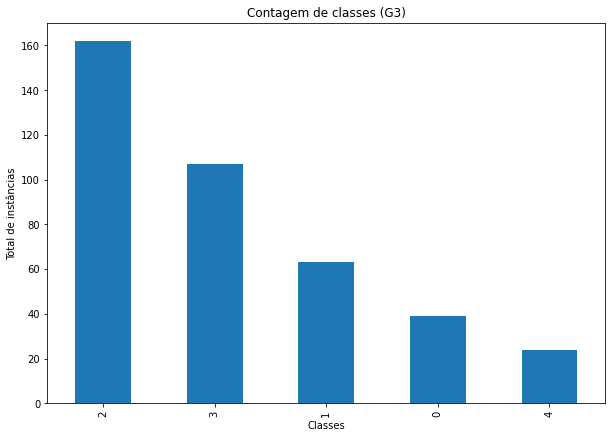

In [16]:
target_count = data.G3.value_counts()
plt.figure(figsize=(10, 7))
plt.xlabel('Classes')
plt.ylabel('Total de instâncias')
target_count.plot(kind='bar', title='Contagem de classes (G3)')

Bom, o desabalanceamento dos dados persistiu após o redimensionamento das classes, o que já era de se esperar. Fazendo uma análise do comportamento dos dados através desse gráfico, fica mais evidente a maiora dos alunos tem notas medianas, pois a classe 2, que representa o intervalo de notas entre 9 e 12, aparece com maior número de alunos. Lembrando que a escala de notas é de 0 a 20.

Vamos treinar um novo modelo e ver seu resultado.

In [17]:
X = data.iloc[:,:-1]
y = data.G3

X = (X - X.min()) / (X.max() - X.min())

In [18]:
mlp_02 = RandomizedSearchCV(
    MLPClassifier(),
    param_grid,
    cv=10,
    scoring='accuracy'
)

In [19]:
mlp_02.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_fun=15000, max_iter=200,
                                           momentum=0.9, n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           rando...
                                           verbose=False, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions=[{

In [20]:
mlp_02_best_params = mlp_02.best_params_

print('BEST PARAMETERS')
for key, value in mlp_02_best_params.items():
    print(key + ':', value)

BEST PARAMETERS
solver: adam
max_iter: 500
hidden_layer_sizes: (50, 100)
activation: logistic


In [21]:
print('Accuracy:', round(mlp_02.best_score_, 3)*100)

Accuracy: 71.89999999999999


## Discutindo resultados do segundo modelo

O segundo modelo, escolhido no espaço de soluções, teve uma performance bem melhor do que o primeiro modelo. A melhora na acurácia deve estar relacionada ao processo de redimensionamento das classes que, mesmo com desbalanceamento das classes persistindo, a diferença entre elas diminuiu consideravelmente. Outro motivo da melhora no resultado se dá pelo fato de as novas classes terem dado uma maior significado ao comportamento dos dados, já que cada nova classe representa uma faixa de valores.

## Treinando o modelo com balanceamento de dados utilizando resampling e diminuir o número de classes

Nessa abordagem será feito uma reamostragem dos dados com o intuito de eliminar o desbalanceamento das classes. O método de reamostragem utilizado aqui serpa o **oversampling**, que consiste em criar novas instâncias - aleatoriamente - para as classes minoritárias a fim de igualar o total de instâncias de acordo com a classe majoritária. O efeito final do oversampling, além de igualar as classes, é o aumento de instâncias no dataset.

No estado atual do dataset já temos as nossas classes redimensionadas (veja abaixo), então o que nos resta é fazer o oversampling.

In [22]:
print('Classes:')
for i in data.G3.unique():
    print(i)

Classes:
1
2
3
4
0


In [23]:
count_class_0 = data.query('G3 == 0').shape[0]
count_class_1 = data.query('G3 == 1').shape[0]
count_class_2 = data.query('G3 == 2').shape[0]
count_class_3 = data.query('G3 == 3').shape[0]
count_class_4 = data.query('G3 == 4').shape[0]

print("Classe 0:", count_class_0)
print("Classe 1:", count_class_1)
print("Classe 2:", count_class_2)
print("Classe 3:", count_class_3)
print("Classe 4:", count_class_4)

Classe 0: 39
Classe 1: 63
Classe 2: 162
Classe 3: 107
Classe 4: 24


Acima temos a quantidade de instâncias por classe. Nas próximas duas células acontece as seguintes operações:

- armazena-se as instâncias de cada classe;
- em seguida a função `sample` é chamada pelos conjuntos que serão reamostrados pela classe majoritária, que no código é `count_class_2` e o parâmetro `replace` diz para a função se as alterações serão persistidas no objeto;
- por fim, a função `pd.concat` cria um novo objeto `DataFrame` armazenado em `data_over`.

In [24]:
data_0 = data.query('G3 == 0')
data_1 = data.query('G3 == 1')
data_2 = data.query('G3 == 2')
data_3 = data.query('G3 == 3')
data_4 = data.query('G3 == 4')

data_class_0_over = data_0.sample(count_class_2, replace=True)
data_class_1_over = data_1.sample(count_class_2, replace=True)
data_class_3_over = data_3.sample(count_class_2, replace=True)
data_class_4_over = data_4.sample(count_class_2, replace=True)

print(len(data_class_0_over))
print(len(data_class_1_over))
print(len(data_class_3_over))
print(len(data_class_4_over))

162
162
162
162


In [25]:
data_over = pd.concat(
    [data_class_0_over, data_class_1_over, data_2, data_class_3_over, data_class_4_over],
    axis=0
)

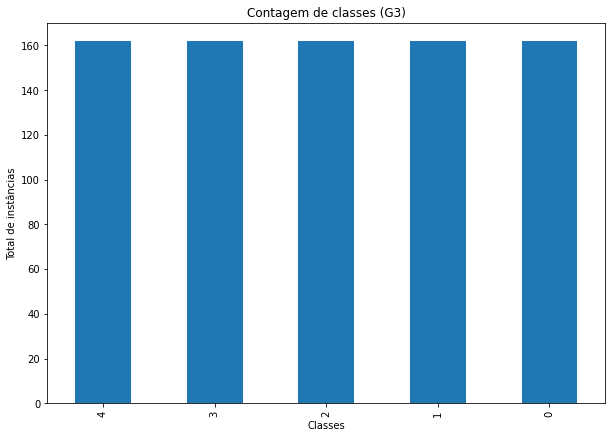

In [26]:
plt.figure(figsize=(10, 7))
plt.xlabel('Classes')
plt.ylabel('Total de instâncias')
data_over.G3.value_counts().plot(kind='bar', title='Contagem de classes (G3)')
plt.show()

In [27]:
X = data_over.iloc[:,:-1]
y = data_over.G3

X = (X - X.min()) / (X.max() - X.min())

In [28]:
mlp_03 = RandomizedSearchCV(
    MLPClassifier(),
    param_grid,
    cv=10,
    scoring='accuracy'
)

In [29]:
mlp_03.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_fun=15000, max_iter=200,
                                           momentum=0.9, n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           rando...
                                           verbose=False, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions=[{

In [30]:
mlp_03_best_params = mlp_03.best_params_

print('BEST PARAMETERS')
for key, value in mlp_03_best_params.items():
    print(key + ':', value)

BEST PARAMETERS
solver: adam
max_iter: 1000
hidden_layer_sizes: (50, 100)
activation: relu


In [31]:
print('Accuracy:', round(mlp_03.best_score_, 3)*100)

Accuracy: 91.9


## Discussão dos resultados

O modelo 3 teve a melhor acurácia, cerca de 91%. Um ótimo número à primeira vista, mas vale discutir algumas coisas aqui sobre este trabalho:

- Não estamos utilizando o mesmo modelo para comparar as 3 abordagens de pré-processamento de dados que foram definidas no início. A estratégia adoatada foi a utilização do método de otimização de parâmetros - utilizando o método random search - para obter o melhor conjunto de parâmetros para o modelo em cada abordagem de pré-processamento.

- Vale frizar que o espaço de soluções utilizado foi o mesmo durante todo o trabalho.

- Para a otimização de parâmetros, o método Random Search consegue escolher a melhor configuração para o modelo mas a sua característica de escolher, de forma randômica, um subconjunto do espaço de soluções, pode deixar de forma algum(ns) parâmetro(s) que poderiam ter uma performance melhor.

- O dataset na sua forma original tem a variável `G3` como target, o que nos mostra que a tarefa de classificação é prever qual é a nota do aluno de acordo com suas características. Quando reduzimos o número de classes atribuindo uma faixa de valores a um novo valor, o trabalho de predição passa a ser "a qual classe o(a) aluno(a) x pertence de acordo com suas características?". Ter uma classe representando um conjunto de valores faz com que uma classe seja mais generalista no que diz respeito às características que pretencem a uma classe pode facilitar o treinamento do modelo porque ele precisa aprender os padrões relacionados a um conjunto menor de possibilidades.